In [148]:
import cv2 as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

In [200]:
src_img = cv2.imread('src.jpg')
dst_img1 = cv2.imread('dst_1.jpg')
dst_img2 = cv2.imread('dst_2.jpg')

In [210]:
def method1(src_img, dst_img, min_match_count=10):
    img1 = src_img.copy()
    img2 = dst_img.copy()

    sift = cv.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=6)
    search_params = dict(checks=100)

    flann = cv.FlannBasedMatcher(index_params, search_params)

    while True:
      matches = flann.knnMatch(des1, des2, k=2)
      # Apply Lowe's ratio test
      good = []
      for m, n in matches:
          if m.distance < 0.7 * n.distance:
              good.append(m)

      if len(good) > min_match_count:
          
          src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
          dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

          M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
          matchesMask = mask.ravel().tolist()
          
          #Преобразование углов изображения
          h, w, _ = img1.shape
          pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
          dst = cv.perspectiveTransform(pts, M)

          img2 = cv.polylines(img2, [np.int32(dst)], True, (0, 255, 0), 3, cv.LINE_AA)
      else:
          break

      # Draw matches
      draw_params = dict(matchColor=(0, 255, 0),  # Draw matches in green color
                        singlePointColor=(255,0,0),
                        matchesMask=matchesMask,  # Draw only inliers
                        flags=0)

      img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

      plt.figure(figsize=(12, 6))
      plt.imshow(img3, 'gray')
      plt.show()

      used_indices = [m.trainIdx for m in good]
      kp2 = [kp for i, kp in enumerate(kp2) if i not in used_indices]
      des2 = np.delete(des2, used_indices, axis=0)
    return img2

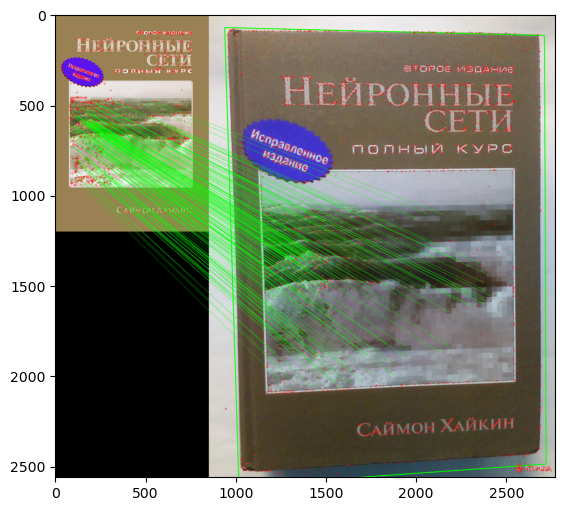

In [220]:
image = method1(src_img, dst_img1, 30)

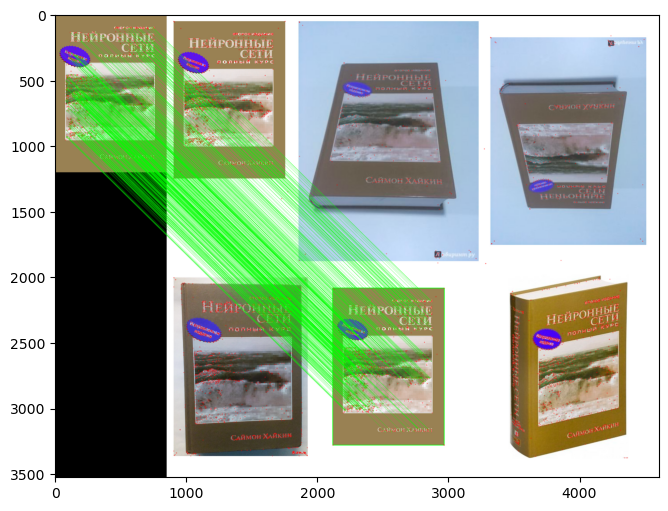

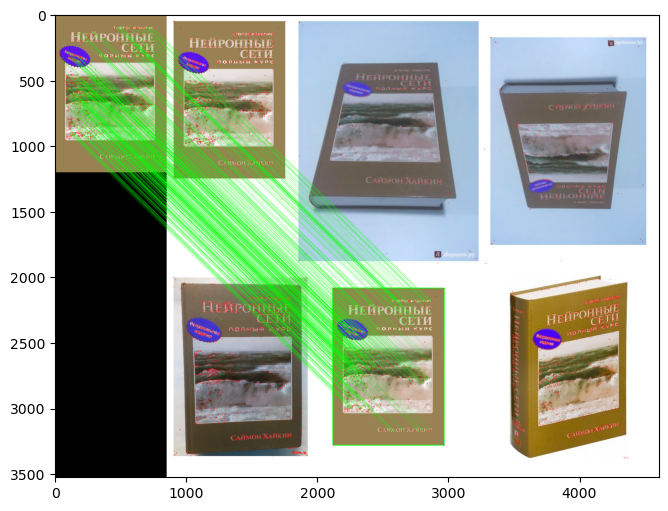

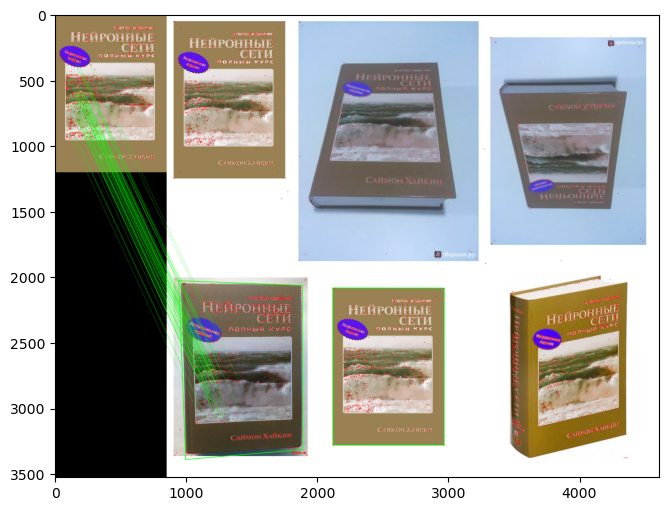

In [226]:
image = method1(src_img,dst_img2, 30)

In [230]:
def method2(src_img, dst_img, min_match_count=10,q=0.2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(src_img, None)
    kp2, des2 = sift.detectAndCompute(dst_img, None)

    # преобразуем ключевые точки в массив координат для 2 изобр
    pts = np.array([kp.pt for kp in kp2], dtype=np.float32)

    # оценка ширины окна для кластеризации
    bandwidth = estimate_bandwidth(pts, quantile=q, n_samples=500)

    # кластеризация ключевых точек
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(pts)
    labels = ms.labels_

    n_clusters_ = len(np.unique(labels))
    print("Число кластеров:", n_clusters_)

    # делим ключ точки и дескрипторы по кластерам
    cluster_kps = [[] for _ in range(n_clusters_)]
    cluster_des = [[] for _ in range(n_clusters_)]
    for i, lbl in enumerate(labels):
        cluster_kps[lbl].append(kp2[i])
        cluster_des[lbl].append(des2[i])

    for i in range(n_clusters_):
        cluster_des[i] = np.array(cluster_des[i], dtype=np.float32)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)

    img_draw = dst_img.copy()

    rng = np.random.default_rng()

    for cluster_idx in range(n_clusters_):
        color = list(np.random.random(size=3) * 256)

        # отрисуем ключевые точки текущего кластера
        for kp in cluster_kps[cluster_idx]:
            x, y = kp.pt
            cv.circle(img_draw, (int(x), int(y)), 10, color, -1)

        matches = flann.knnMatch(des1, cluster_des[cluster_idx], k=2)

        good = []
        for m, n in matches:
            # фильтруем совпадения с помощью Lowe's Ratio Test
            if m.distance < 0.5 * n.distance:
                good.append(m)

        if len(good) >= min_match_count:
            # извлекаем координаты совпадающих точек
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([cluster_kps[cluster_idx][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            if M is not None:
                matchesMask = mask.ravel().tolist()

                h, w, _ = src_img.shape
                pts_obj = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                dst = cv.perspectiveTransform(pts_obj, M)

                cv.polylines(img_draw, [np.int32(dst)], True, (0, 255, 0), 15, cv.LINE_AA)

                draw_params = dict(matchColor=(0, 255, 0),  # Draw matches in green color
                        singlePointColor=(255,0,0),
                        matchesMask=matchesMask,  # Draw only inliers
                        flags=0)

                img3 = cv.drawMatches(src_img, kp1, dst_img, cluster_kps[cluster_idx], good, None, **draw_params)

                plt.figure(figsize=(12, 6))
                plt.imshow(img3, 'gray')
                plt.show()


    return img_draw

Число кластеров: 6


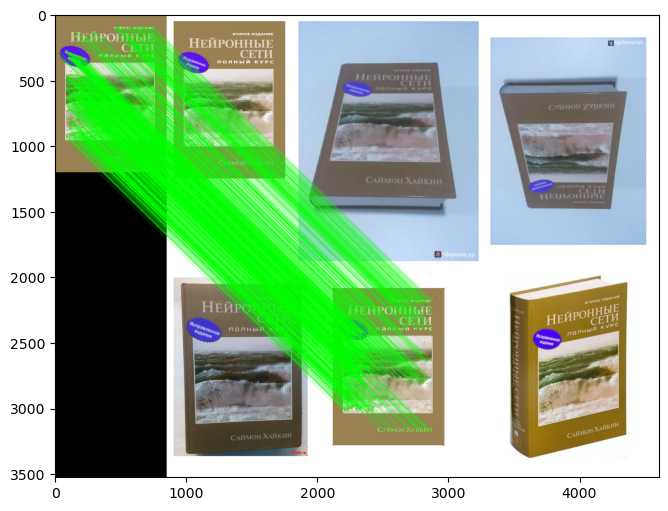

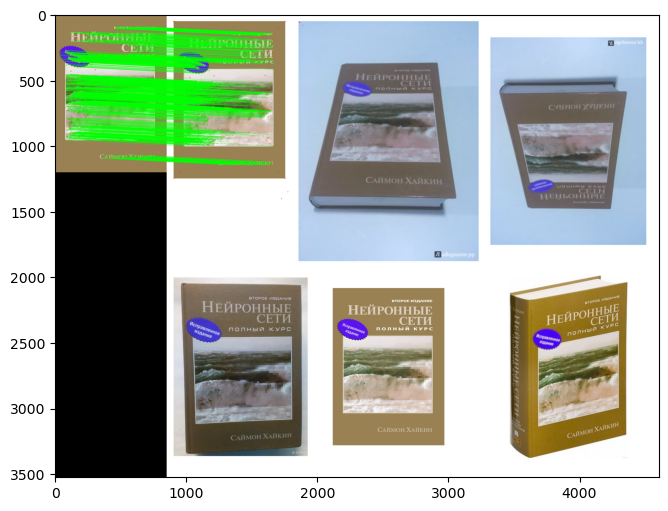

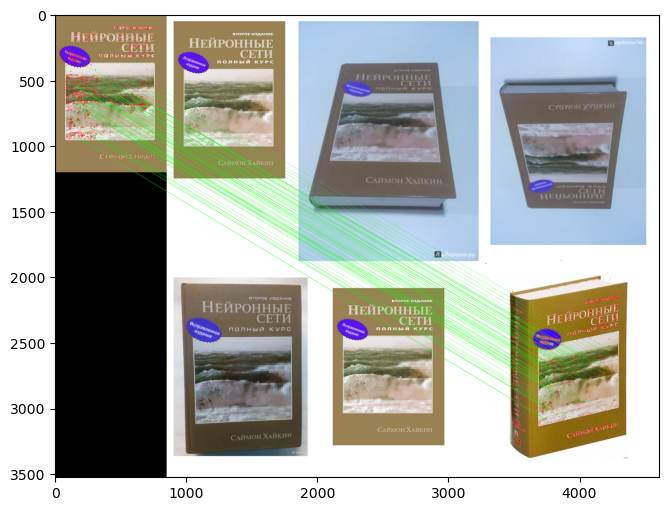

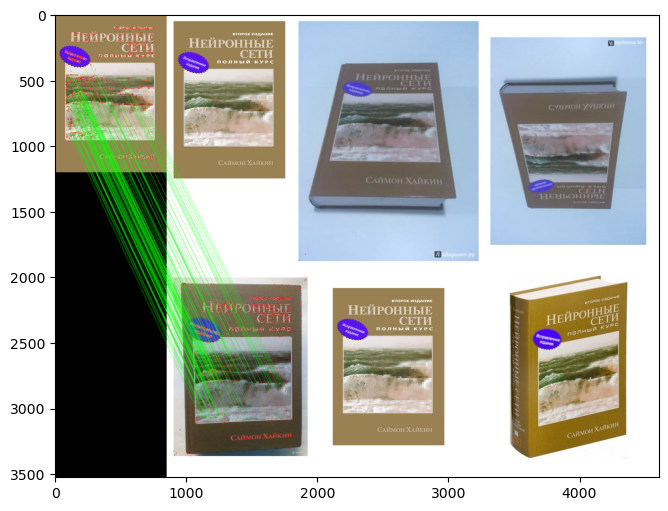

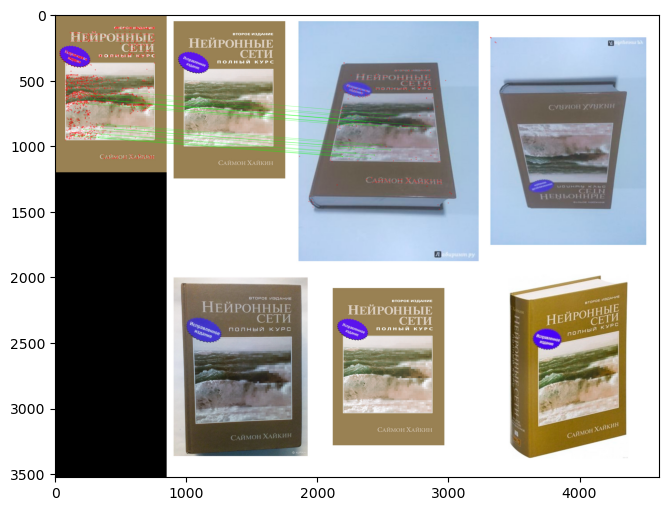

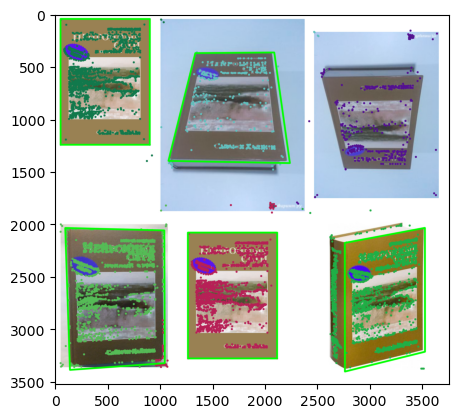

In [234]:
image = method2(src_img,dst_img2,30,0.15)
plt.imshow(image)

Число кластеров: 1


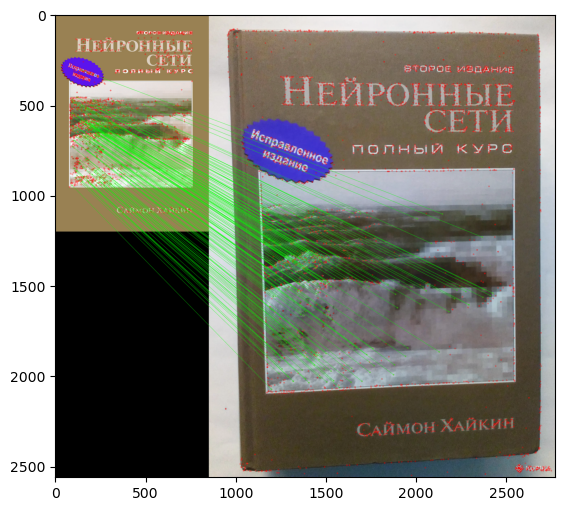

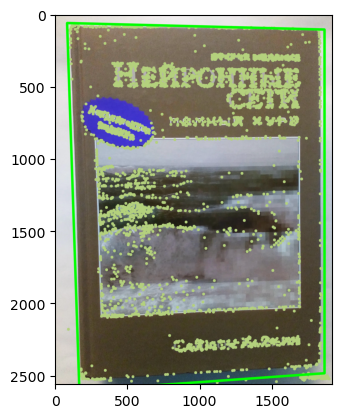

In [236]:
image = method2(src_img,dst_img1,10,0.5)
plt.imshow(image)